<a href="https://colab.research.google.com/github/AtakaNKuscu/Physics-Informed-Neural-Networks/blob/main/underdampedsystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = "cuda" if torch.cuda.is_available() else "cpu"

In [136]:
torch.manual_seed(42)

In [137]:
# ----- Sistem Parametreleri (Underdamped) -----
zeta = 0.2
wn = 2.0

In [138]:
# ODE: y'' + 2*zeta*wn*y' + wn^2*y = wn^2
a1 = 2 * zeta * wn        # 0.8
a0 = wn**2                # 4.0
rhs = wn**2               # 4.0

print(f"ODE: y'' + {a1} y' + {a0} y = {rhs}")

ODE: y'' + 0.8 y' + 4.0 y = 4.0


In [139]:
# ----- Neural Network -----
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, t):
        return self.layers(t)

model = Net().to(device)

In [140]:
# ----- Physics residual: y'' + a1*y' + a0*y = rhs -----
def residual(t):
    t.requires_grad_(True)
    y = model(t)                          # y(t)
    dy_dt = torch.autograd.grad(          # y'(t)
        y, t,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]
    d2y_dt2 = torch.autograd.grad(        # y''(t)
        dy_dt, t,
        grad_outputs=torch.ones_like(dy_dt),
        create_graph=True
    )[0]
    return d2y_dt2 + a1*dy_dt + a0*y - rhs   # = 0 olmalı

In [141]:
# ----- Training points -----
Nf = 200
t_f = torch.linspace(0, 10, Nf).view(-1,1).to(device)  # collocation points, 0-10 sn

# Boundary conditions: y(0) = 0, y'(0) = 0
t0 = torch.tensor([[0.0]], device=device)
y0_true = torch.tensor([[0.0]], device=device)
dy0_true = torch.tensor([[0.0]], device=device)

In [142]:
# For plotting
loss_history = []
epochs = 10000  # underdamped için biraz daha uzun eğitim

# Test grid for plotting NN prediction
t_test = torch.linspace(0, 10, 400).view(-1,1).to(device)
t_np = t_test.cpu().numpy()

In [143]:
# ----- Exact underdamped step response -----
# y(t) = 1 - (1/sqrt(1-zeta^2)) * exp(-zeta*wn*t) * sin(omega_d*t + phi)
omega_d = wn * np.sqrt(1 - zeta**2)
phi = np.arccos(zeta)

y_true = 1 - (1/np.sqrt(1-zeta**2)) * np.exp(-zeta*wn*t_np) * np.sin(omega_d*t_np + phi)

Adam optimizasyonu başlıyor...
Adam Epoch: 0, Loss: 25.015118
Adam Epoch: 500, Loss: 0.170777
Adam Epoch: 1000, Loss: 0.070777
Adam Epoch: 1500, Loss: 0.041332
Adam Epoch: 2000, Loss: 0.026917
Adam Epoch: 2500, Loss: 0.014043

L-BFGS optimizasyonuna geçiliyor (Spike'ları temizlemek için)...
Eğitim Tamamlandı.


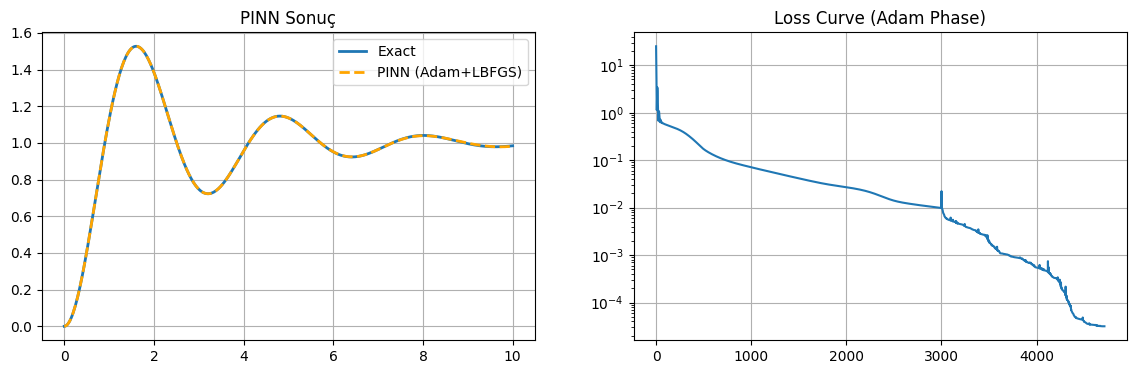

In [144]:
# ----------------------------------------------------------------
# AŞAMA 1: ADAM (Kaba Taslak Eğitim)
# ----------------------------------------------------------------
print("Adam optimizasyonu başlıyor...")
optimizer_adam = torch.optim.Adam(model.parameters(), lr=1e-3)

# Adam ile 2000-3000 epoch yeterlidir, fazlası spike yapar.
for epoch in range(3000):
    optimizer_adam.zero_grad()

    # Physics loss
    f = residual(t_f)
    loss_phys = torch.mean(f**2)

    # BC: y(0) = 0
    t0.requires_grad_(True)
    y0 = model(t0)
    loss_bc_y = torch.mean((y0 - y0_true)**2)

    # BC: y'(0) = 0
    dy0 = torch.autograd.grad(y0, t0, grad_outputs=torch.ones_like(y0), create_graph=True)[0]
    loss_bc_dy = torch.mean((dy0 - dy0_true)**2)

    # Physics katsayısını 1.0 yapalım, model denklemi daha ciddiye alsın
    loss = 1.0 * loss_phys + loss_bc_y + loss_bc_dy

    loss.backward()
    optimizer_adam.step()

    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Adam Epoch: {epoch}, Loss: {loss.item():.6f}")

# ----------------------------------------------------------------
# AŞAMA 2: L-BFGS (İnce Ayar - Spike Önleyici)
# ----------------------------------------------------------------
print("\nL-BFGS optimizasyonuna geçiliyor (Spike'ları temizlemek için)...")

# L-BFGS genellikle lr=1.0 ile başlatılır.
optimizer_lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=50000,
    max_eval=50000,
    history_size=50,
    tolerance_grad=1e-6,
    tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe"       # Bu parametre çok önemlidir, kararlılık sağlar
)

# L-BFGS 'closure' denilen bir fonksiyon ister
def closure():
    optimizer_lbfgs.zero_grad()

    # Physics loss
    f = residual(t_f)
    loss_phys = torch.mean(f**2)

    # BC: y(0) = 0
    y0 = model(t0)
    loss_bc_y = torch.mean((y0 - y0_true)**2)

    # BC: y'(0) = 0
    dy0 = torch.autograd.grad(y0, t0, grad_outputs=torch.ones_like(y0), create_graph=True)[0]
    loss_bc_dy = torch.mean((dy0 - dy0_true)**2)

    loss = 1.0 * loss_phys + loss_bc_y + loss_bc_dy
    loss.backward()

    # Loss geçmişini buradan da ekleyebilirsin ama grafik çok hızlı dolabilir
    loss_history.append(loss.item())
    return loss

# Tek bir step komutuyla tüm L-BFGS eğitimi döner
optimizer_lbfgs.step(closure)

print("Eğitim Tamamlandı.")

# ----------------------------------------------------------------
# GÖRSELLEŞTİRME
# ----------------------------------------------------------------
with torch.no_grad():
    y_pred = model(t_test).cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# Plot 1: Çözüm
axs[0].plot(t_np, y_true, label="Exact", linewidth=2)
axs[0].plot(t_np, y_pred, "--", label="PINN (Adam+LBFGS)", linewidth=2, color="orange")
axs[0].set_title("PINN Sonuç")
axs[0].legend()
axs[0].grid()

# Plot 2: Loss (Sadece Adam kısmını çizdirir, LBFGS çok hızlı düşer)
axs[1].plot(loss_history, label="Loss (Adam Phase + After 3000 epoch LBFGS)")
axs[1].set_yscale("log")
axs[1].set_title("Loss Curve (Adam Phase)")
axs[1].grid()

plt.show()